In [1]:
from fastTSNE import TSNE, TSNEEmbedding
from fastTSNE.callbacks import ErrorLogger
from fastTSNE import affinity, initialization

from examples import utils

import numpy as np
import scipy.sparse as sp
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
import gzip
import pickle

with gzip.open("../data/10x_mouse_zheng.pkl.gz", "rb") as f:
    data = pickle.load(f)

x = data["pca_50"]
y = data["CellType1"]

In [3]:
print("Data set contains %d samples with %d features" % x.shape)

Data set contains 1306127 samples with 50 features


In [4]:
def plot(x, y, **kwargs):
    utils.plot(
        x,
        y,
        colors=utils.MOUSE_10X_COLORS,
        alpha=kwargs.pop("alpha", 0.1),
        draw_legend=False,
        **kwargs,
    )

In [5]:
def rotate(degrees):
    phi = degrees * np.pi / 180
    return np.array([
        [np.cos(phi), -np.sin(phi)],
        [np.sin(phi), np.cos(phi)],
    ])

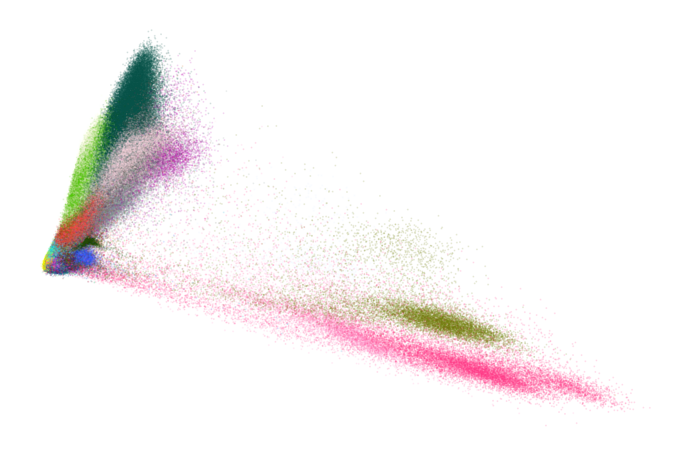

In [6]:
plot(x, y)

Precompute the full affinities.

In [7]:
%%time
affinities = affinity.PerplexityBasedNN(
    x,
    perplexity=30,
    n_jobs=8,
    random_state=0,
)

CPU times: user 38min 39s, sys: 13.6 s, total: 38min 52s
Wall time: 24min 56s


## Create train/test split

In [8]:
np.random.seed(0)

In [9]:
indices = np.random.permutation(list(range(x.shape[0])))
reverse = np.argsort(indices)

x_sample, x_rest = x[indices[:25000]], x[indices[25000:]]
y_sample, y_rest = y[indices[:25000]], y[indices[25000:]]

## Make sample embedding

In [10]:
%%time
sample_affinities = affinity.PerplexityBasedNN(
    x_sample,
    perplexity=500,
    method="approx",
    n_jobs=8,
    random_state=0,
)

CPU times: user 5min 5s, sys: 1.5 s, total: 5min 6s
Wall time: 1min 20s


In [11]:
%time sample_init = initialization.pca(x_sample, random_state=42)

CPU times: user 216 ms, sys: 24 ms, total: 240 ms
Wall time: 39.9 ms


In [12]:
sample_embedding = TSNEEmbedding(
    sample_init,
    sample_affinities,
    negative_gradient_method="fft",
    n_jobs=8,
    callbacks=ErrorLogger(),
)

In [13]:
%time sample_embedding1 = sample_embedding.optimize(n_iter=250, exaggeration=12, momentum=0.5)

Iteration   50, KL divergence  3.1707, 50 iterations in 5.8968 sec
Iteration  100, KL divergence  3.0522, 50 iterations in 6.0476 sec
Iteration  150, KL divergence  3.0464, 50 iterations in 5.8998 sec
Iteration  200, KL divergence  3.0449, 50 iterations in 5.9616 sec
Iteration  250, KL divergence  3.0443, 50 iterations in 6.2344 sec
CPU times: user 4min 2s, sys: 760 ms, total: 4min 3s
Wall time: 30.5 s


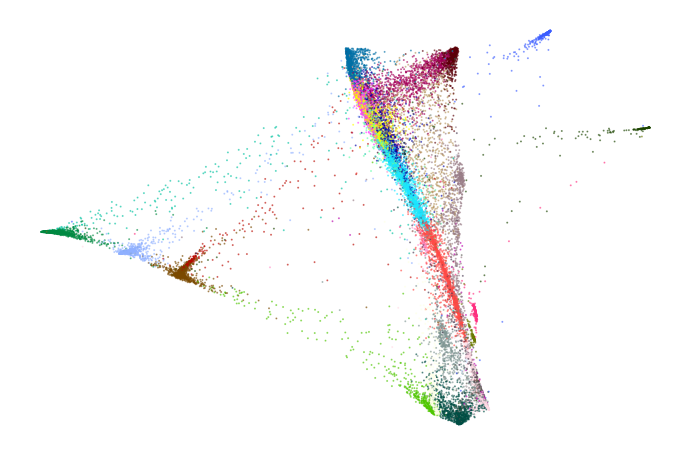

In [14]:
plot(sample_embedding1, y[indices[:25000]], alpha=0.5)

In [15]:
%time sample_embedding2 = sample_embedding1.optimize(n_iter=750, exaggeration=1, momentum=0.8)

Iteration   50, KL divergence  1.5281, 50 iterations in 6.1395 sec
Iteration  100, KL divergence  1.3389, 50 iterations in 6.0844 sec
Iteration  150, KL divergence  1.2583, 50 iterations in 6.3079 sec
Iteration  200, KL divergence  1.2150, 50 iterations in 6.4004 sec
Iteration  250, KL divergence  1.1948, 50 iterations in 6.5539 sec
Iteration  300, KL divergence  1.1771, 50 iterations in 6.4223 sec
Iteration  350, KL divergence  1.1670, 50 iterations in 6.3885 sec
Iteration  400, KL divergence  1.1595, 50 iterations in 6.5070 sec
Iteration  450, KL divergence  1.1536, 50 iterations in 6.5603 sec
Iteration  500, KL divergence  1.1494, 50 iterations in 7.0096 sec
Iteration  550, KL divergence  1.1456, 50 iterations in 7.1817 sec
Iteration  600, KL divergence  1.1432, 50 iterations in 7.6505 sec
Iteration  650, KL divergence  1.1411, 50 iterations in 6.5691 sec
Iteration  700, KL divergence  1.1397, 50 iterations in 6.7194 sec
Iteration  750, KL divergence  1.1383, 50 iterations in 6.6007

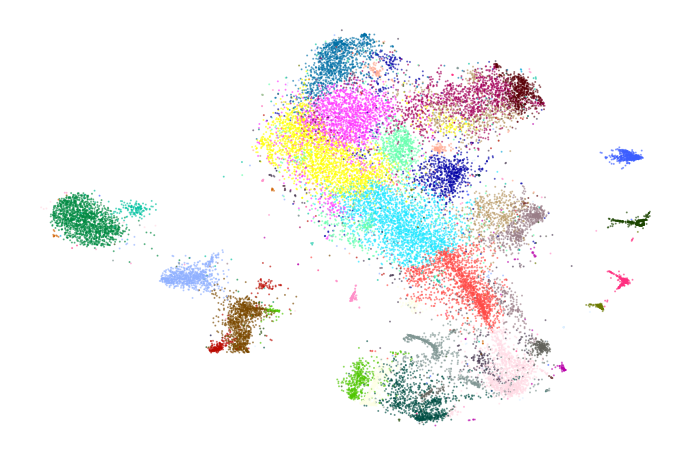

In [16]:
plot(sample_embedding2, y[indices[:25000]], alpha=0.5)

## Learn the full embedding

In [17]:
%time rest_init = sample_embedding2.prepare_partial(x_rest, k=1, perplexity=1/3)

CPU times: user 48.7 s, sys: 268 ms, total: 48.9 s
Wall time: 35.5 s


In [18]:
init_full = np.vstack((sample_embedding2, rest_init))[reverse]

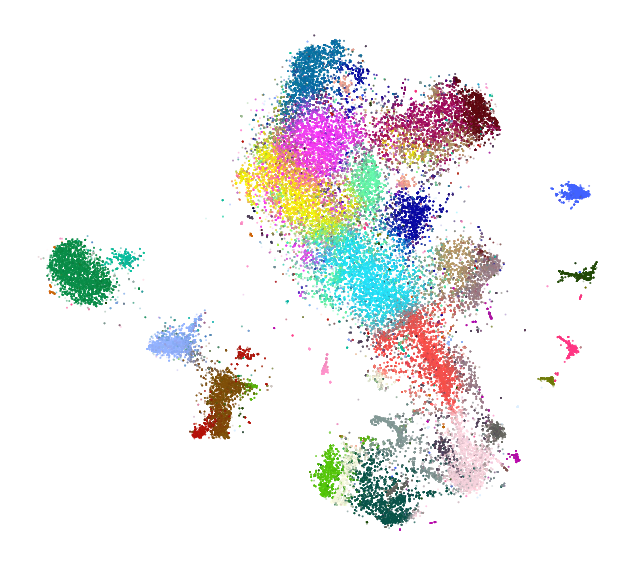

In [19]:
fig, ax = plt.subplots(figsize=(11, 10))
plot(init_full, y, ax=ax)

In [20]:
init_full = init_full / (np.std(init_full[:, 0]) * 10000)
np.std(init_full, axis=0)

array([0.0001    , 0.00011403])

In [21]:
embedding = TSNEEmbedding(
    init_full,
    affinities,
    learning_rate=1000,
    negative_gradient_method="fft",
    n_jobs=8,
    callbacks=ErrorLogger(),
    random_state=42,
)

In [22]:
%time embedding1 = embedding.optimize(n_iter=500, exaggeration=12, momentum=0.5)

Iteration   50, KL divergence  10.2843, 50 iterations in 56.9785 sec
Iteration  100, KL divergence  10.2803, 50 iterations in 56.5474 sec
Iteration  150, KL divergence  9.3190, 50 iterations in 57.3148 sec
Iteration  200, KL divergence  8.7463, 50 iterations in 57.1166 sec
Iteration  250, KL divergence  8.5086, 50 iterations in 57.1942 sec
Iteration  300, KL divergence  8.3858, 50 iterations in 56.8681 sec
Iteration  350, KL divergence  8.3118, 50 iterations in 57.3070 sec
Iteration  400, KL divergence  8.2644, 50 iterations in 56.9948 sec
Iteration  450, KL divergence  8.2318, 50 iterations in 56.6485 sec
Iteration  500, KL divergence  8.2095, 50 iterations in 56.6715 sec
CPU times: user 1h 13min 12s, sys: 1min 4s, total: 1h 14min 17s
Wall time: 9min 32s


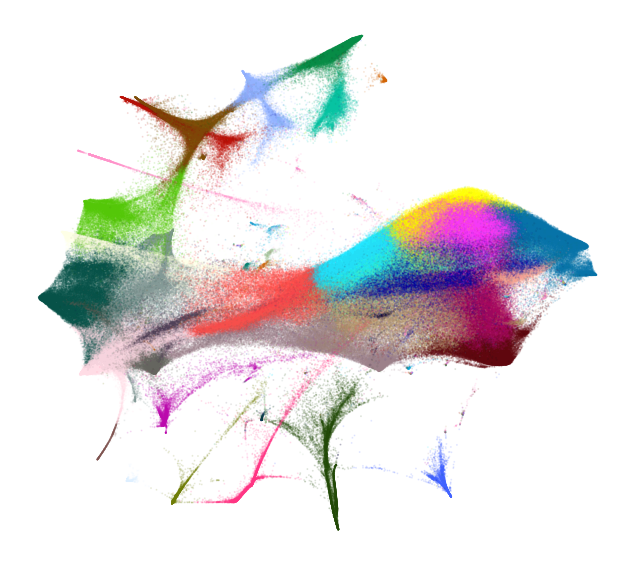

In [23]:
fig, ax = plt.subplots(figsize=(11, 10))
plot(embedding1 @ rotate(90), y, ax=ax)

### No exaggeration

In [24]:
%time embedding2 = embedding1.optimize(n_iter=750, exaggeration=1, momentum=0.8)

Iteration   50, KL divergence  7.4090, 50 iterations in 56.1328 sec
Iteration  100, KL divergence  7.0913, 50 iterations in 56.1467 sec
Iteration  150, KL divergence  6.8774, 50 iterations in 56.8166 sec
Iteration  200, KL divergence  6.7154, 50 iterations in 58.3645 sec
Iteration  250, KL divergence  6.5846, 50 iterations in 59.4526 sec
Iteration  300, KL divergence  6.4756, 50 iterations in 59.7037 sec
Iteration  350, KL divergence  6.3825, 50 iterations in 60.7804 sec
Iteration  400, KL divergence  6.3017, 50 iterations in 61.0211 sec
Iteration  450, KL divergence  6.2302, 50 iterations in 60.4779 sec
Iteration  500, KL divergence  6.1663, 50 iterations in 61.2701 sec
Iteration  550, KL divergence  6.1089, 50 iterations in 61.9637 sec
Iteration  600, KL divergence  6.0568, 50 iterations in 61.3257 sec
Iteration  650, KL divergence  6.0090, 50 iterations in 61.6352 sec
Iteration  700, KL divergence  5.9651, 50 iterations in 61.6618 sec
Iteration  750, KL divergence  5.9246, 50 iterat

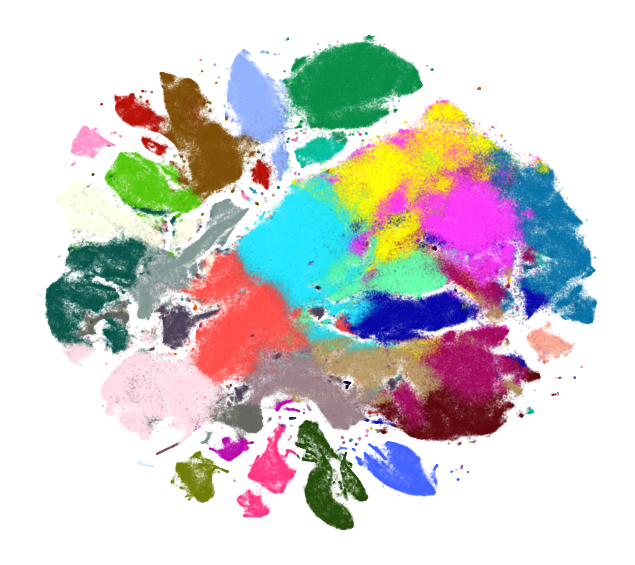

In [25]:
fig, ax = plt.subplots(figsize=(11, 10))
plot(embedding2 @ rotate(90), y, ax=ax)

### With exaggeration

In [26]:
%time embedding3 = embedding1.optimize(n_iter=750, exaggeration=4, momentum=0.8)

Iteration   50, KL divergence  7.6484, 50 iterations in 57.5835 sec
Iteration  100, KL divergence  7.4664, 50 iterations in 57.1662 sec
Iteration  150, KL divergence  7.3579, 50 iterations in 57.2441 sec
Iteration  200, KL divergence  7.2860, 50 iterations in 57.1173 sec
Iteration  250, KL divergence  7.2353, 50 iterations in 57.3436 sec
Iteration  300, KL divergence  7.1975, 50 iterations in 56.7744 sec
Iteration  350, KL divergence  7.1688, 50 iterations in 56.4604 sec
Iteration  400, KL divergence  7.1451, 50 iterations in 56.8742 sec
Iteration  450, KL divergence  7.1263, 50 iterations in 56.7128 sec
Iteration  500, KL divergence  7.1102, 50 iterations in 57.2065 sec
Iteration  550, KL divergence  7.0969, 50 iterations in 57.4542 sec
Iteration  600, KL divergence  7.0852, 50 iterations in 58.1009 sec
Iteration  650, KL divergence  7.0744, 50 iterations in 58.1829 sec
Iteration  700, KL divergence  7.0653, 50 iterations in 58.5190 sec
Iteration  750, KL divergence  7.0565, 50 iterat

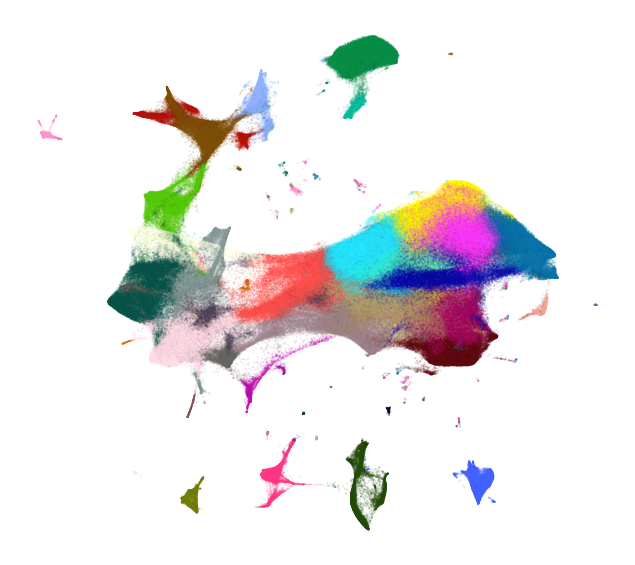

In [27]:
fig, ax = plt.subplots(figsize=(11, 10))
plot(embedding3 @ rotate(90), y, ax=ax)

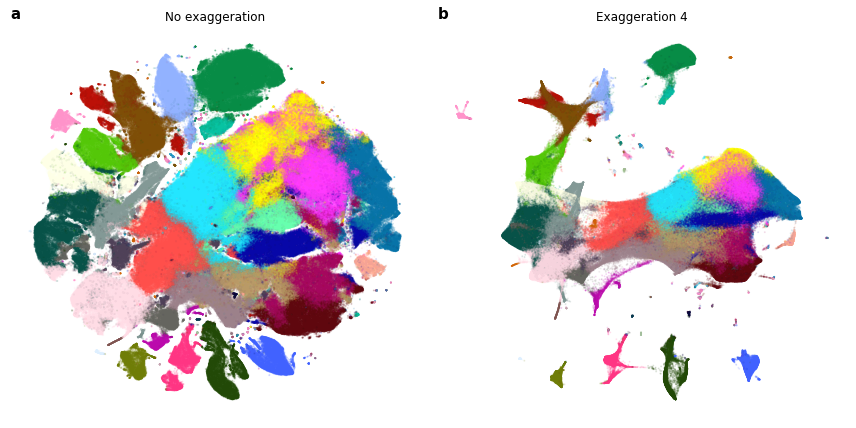

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

plot(embedding2 @ rotate(90), y, title="No exaggeration", ax=ax[0])
plot(embedding3 @ rotate(90), y, title="Exaggeration 4", ax=ax[1])

plt.tight_layout()
plt.text(0, 1.02, "a", transform=ax[0].transAxes, fontsize=15, fontweight="bold")
plt.text(0, 1.02, "b", transform=ax[1].transAxes, fontsize=15, fontweight="bold")

plt.savefig("10x_exaggeration.png", dpi=100, transparent=True)
plt.savefig("10x_exaggeration.pdf", dpi=600, transparent=True)